# Data Preparation

In [1]:
import torch
from Data.quantum_dataset import QuantumDataset

torch.cuda.empty_cache()
potential_type = 'all'
dset = QuantumDataset(potential_type,memory=True)
file_labels = dset.get_labels()

Indexing:   0%|          | 0/5 [00:00<?, ?it/s]

Loading data into memory


Loading files to memory:   0%|          | 0/5 [00:00<?, ?it/s]

## Sample Data

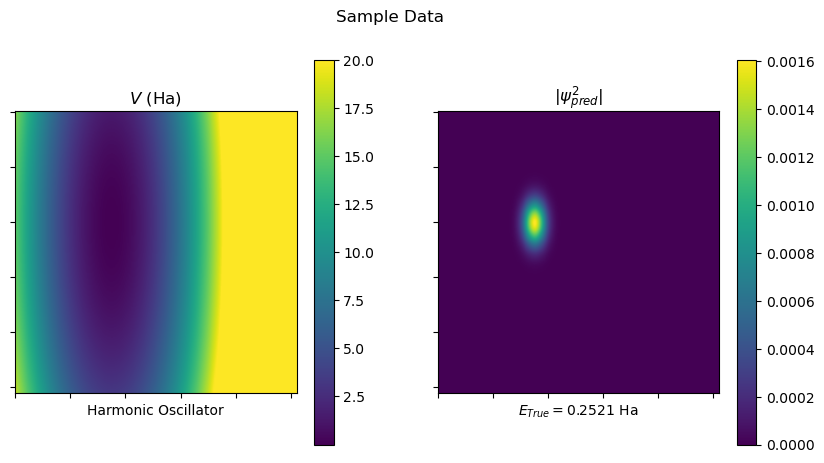

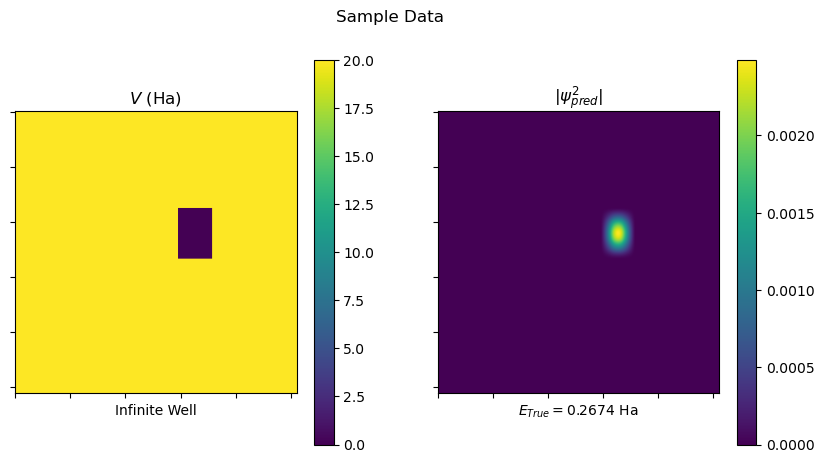

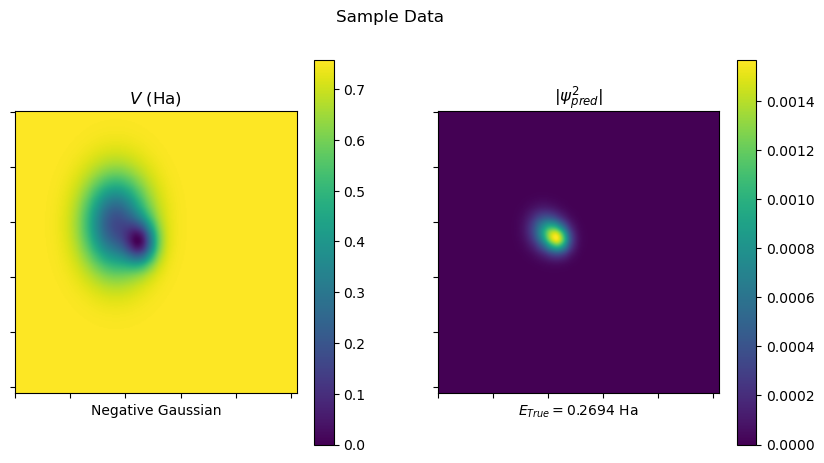

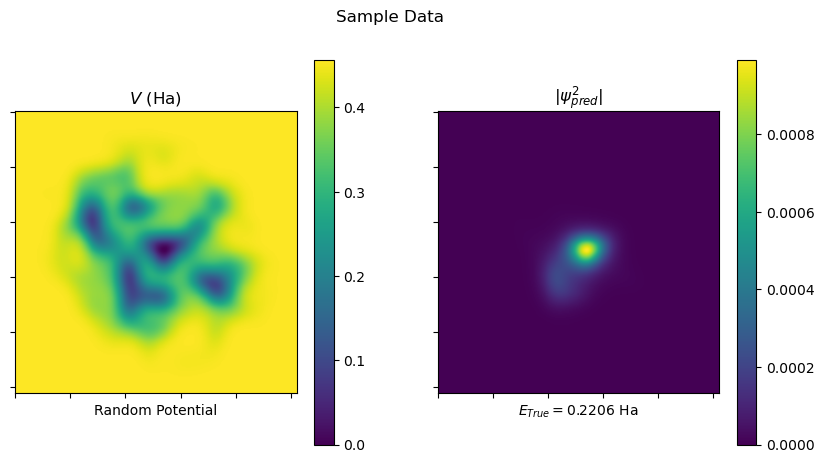

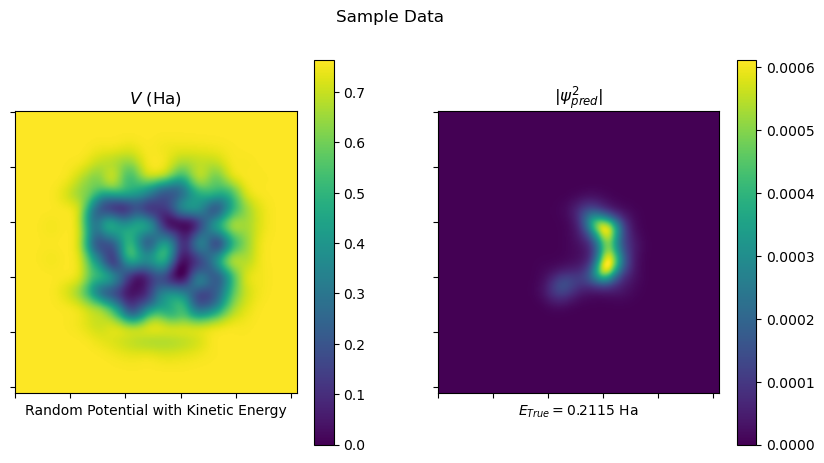

In [2]:
from HelperFunctions.print_image import print_img
sample_idx = [0,5000,10000,15000,20000] if potential_type == 'all' else [0]
for idx in sample_idx:
    potential = dset[idx]['potential']
    wavefunction2 = dset[idx]['wavefunction2']
    energy = dset[idx]['energy']
    potential_index = dset[idx]['potential_index']
    print_img(potential,wavefunction2,'$V$ (Ha)',r'$|\psi^2_{pred}|$','Sample Data',energy,file_labels[potential_index.item()])

## Split Data

In [3]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

seed = 12

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_generator = torch.Generator()
train_generator.manual_seed(seed)

val_generator = torch.Generator()
val_generator.manual_seed(seed)

test_generator = torch.Generator()
test_generator.manual_seed(seed)

train_dataset, test_dataset = train_test_split(dset, test_size=0.2, shuffle=True,random_state=seed)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.2, shuffle=True,random_state=seed)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,generator=train_generator)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True,generator=val_generator)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True,generator=test_generator)

# Part 1

## Train Model

In [4]:
from tqdm.notebook import tqdm
from torch import nn

def energy_test(model:nn.Module,
                dataloader:DataLoader,
                loss_fn:nn.Module,
                device:str,
                validate:bool=False,
                verbose:bool=False,
                display:bool=True)->float:
    """
    Testing loop for the EnergyCNN
    :param model: Model used for testing
    :param dataloader: DataLoader containing validate or test data
    :param loss_fn: Loss function used in training
    :param device: CPU or CUDA
    :param validate: True for validation tests else False
    :param verbose: True for verbosity
    :param display: True for displaying tqdm subbars
    :return: None
    """
    model.eval()
    losses = []
    with torch.inference_mode():
        for data in tqdm(dataloader,leave=False,position=1,display=display):
            potential = data['potential'].to(device)
            energy = data['energy'].to(device)
            energy_pred = model(potential)

            loss = loss_fn(energy_pred, energy)
            losses.append(loss.item())
        average_loss = sum(losses) / len(losses)
        test_type = 'Validation' if validate else 'Test'
        if verbose or test_type == 'Test':
            tqdm.write(f'{test_type} Loss: {average_loss}\n')
    return average_loss

In [5]:
from torch.optim import Optimizer
from HelperFunctions.plot_loss import plot_loss

def energy_train(model:nn.Module,
                 epochs:int,
                 train_dataloader:DataLoader,
                 validation_dataloader:DataLoader,
                 optimizer:Optimizer,
                 loss_fn:nn.Module,
                 device:str='cuda',
                 verbose:bool=False,
                 display:bool=True)->None:
    """
    Training loop for the EnergyCNN
    :param model: Model used for training
    :param epochs: Number of cycles
    :param train_dataloader: Dataloader containing training data
    :param validation_dataloader: Dataloader containing validation data
    :param optimizer: Optimizer used for training
    :param loss_fn: Loss function used in training
    :param device: CPU or CUDA
    :param verbose: True for verbosity
    :param display: True for displaying tqdm subbars
    :return: None
    """
    train_loss_change = []
    test_loss_change = []
    for epoch in tqdm(range(epochs),unit='epochs',position=0):
        model.train()
        losses = []
        for data in tqdm(train_dataloader,unit='batches',leave=False,position=1,display=display):
            optimizer.zero_grad()
            potential = data['potential'].to(device)
            energy_pred = data['energy'].to(device)

            loss = loss_fn(model(potential), energy_pred)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        avg_loss = sum(losses) / len(losses)
        val_loss = energy_test(model,validation_dataloader,loss_fn,device,validate=True,verbose=False,display=display)
        train_loss_change.append(avg_loss)
        test_loss_change.append(val_loss)
        if verbose:
            tqdm.write(f'Epoch {epoch + 1}/{epochs}\nTrain Loss: {avg_loss}')
    plot_loss(train_loss_change,test_loss_change,label1='Train Loss',label2='Validation Loss')

## Loop

  0%|          | 0/100 [00:00<?, ?epochs/s]

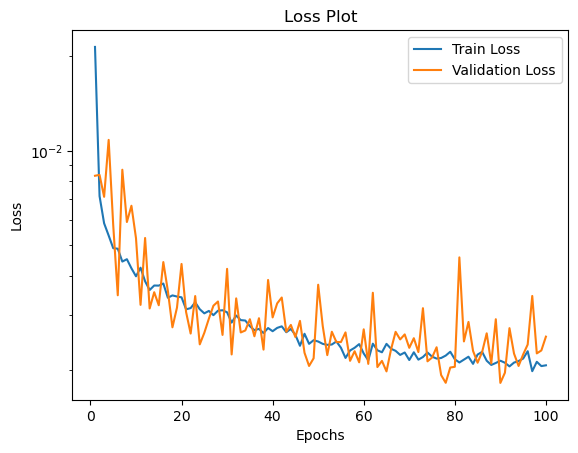

Test Loss: 0.002517225533223952



0.002517225533223952

In [6]:
from energy_cnn import EnergyCNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EnergyCNN(cnn_channels=(64,16,64,16,64,16,64,16),
                  hidden_layers=(128,)
                  ).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.L1Loss()

epochs = 100
energy_train(model,epochs,train_dataloader,validation_dataloader,optimizer,loss_fn,device,verbose=False,display=False)
energy_test(model,test_dataloader,loss_fn,device,validate=False,verbose=False,display=False)


## Results

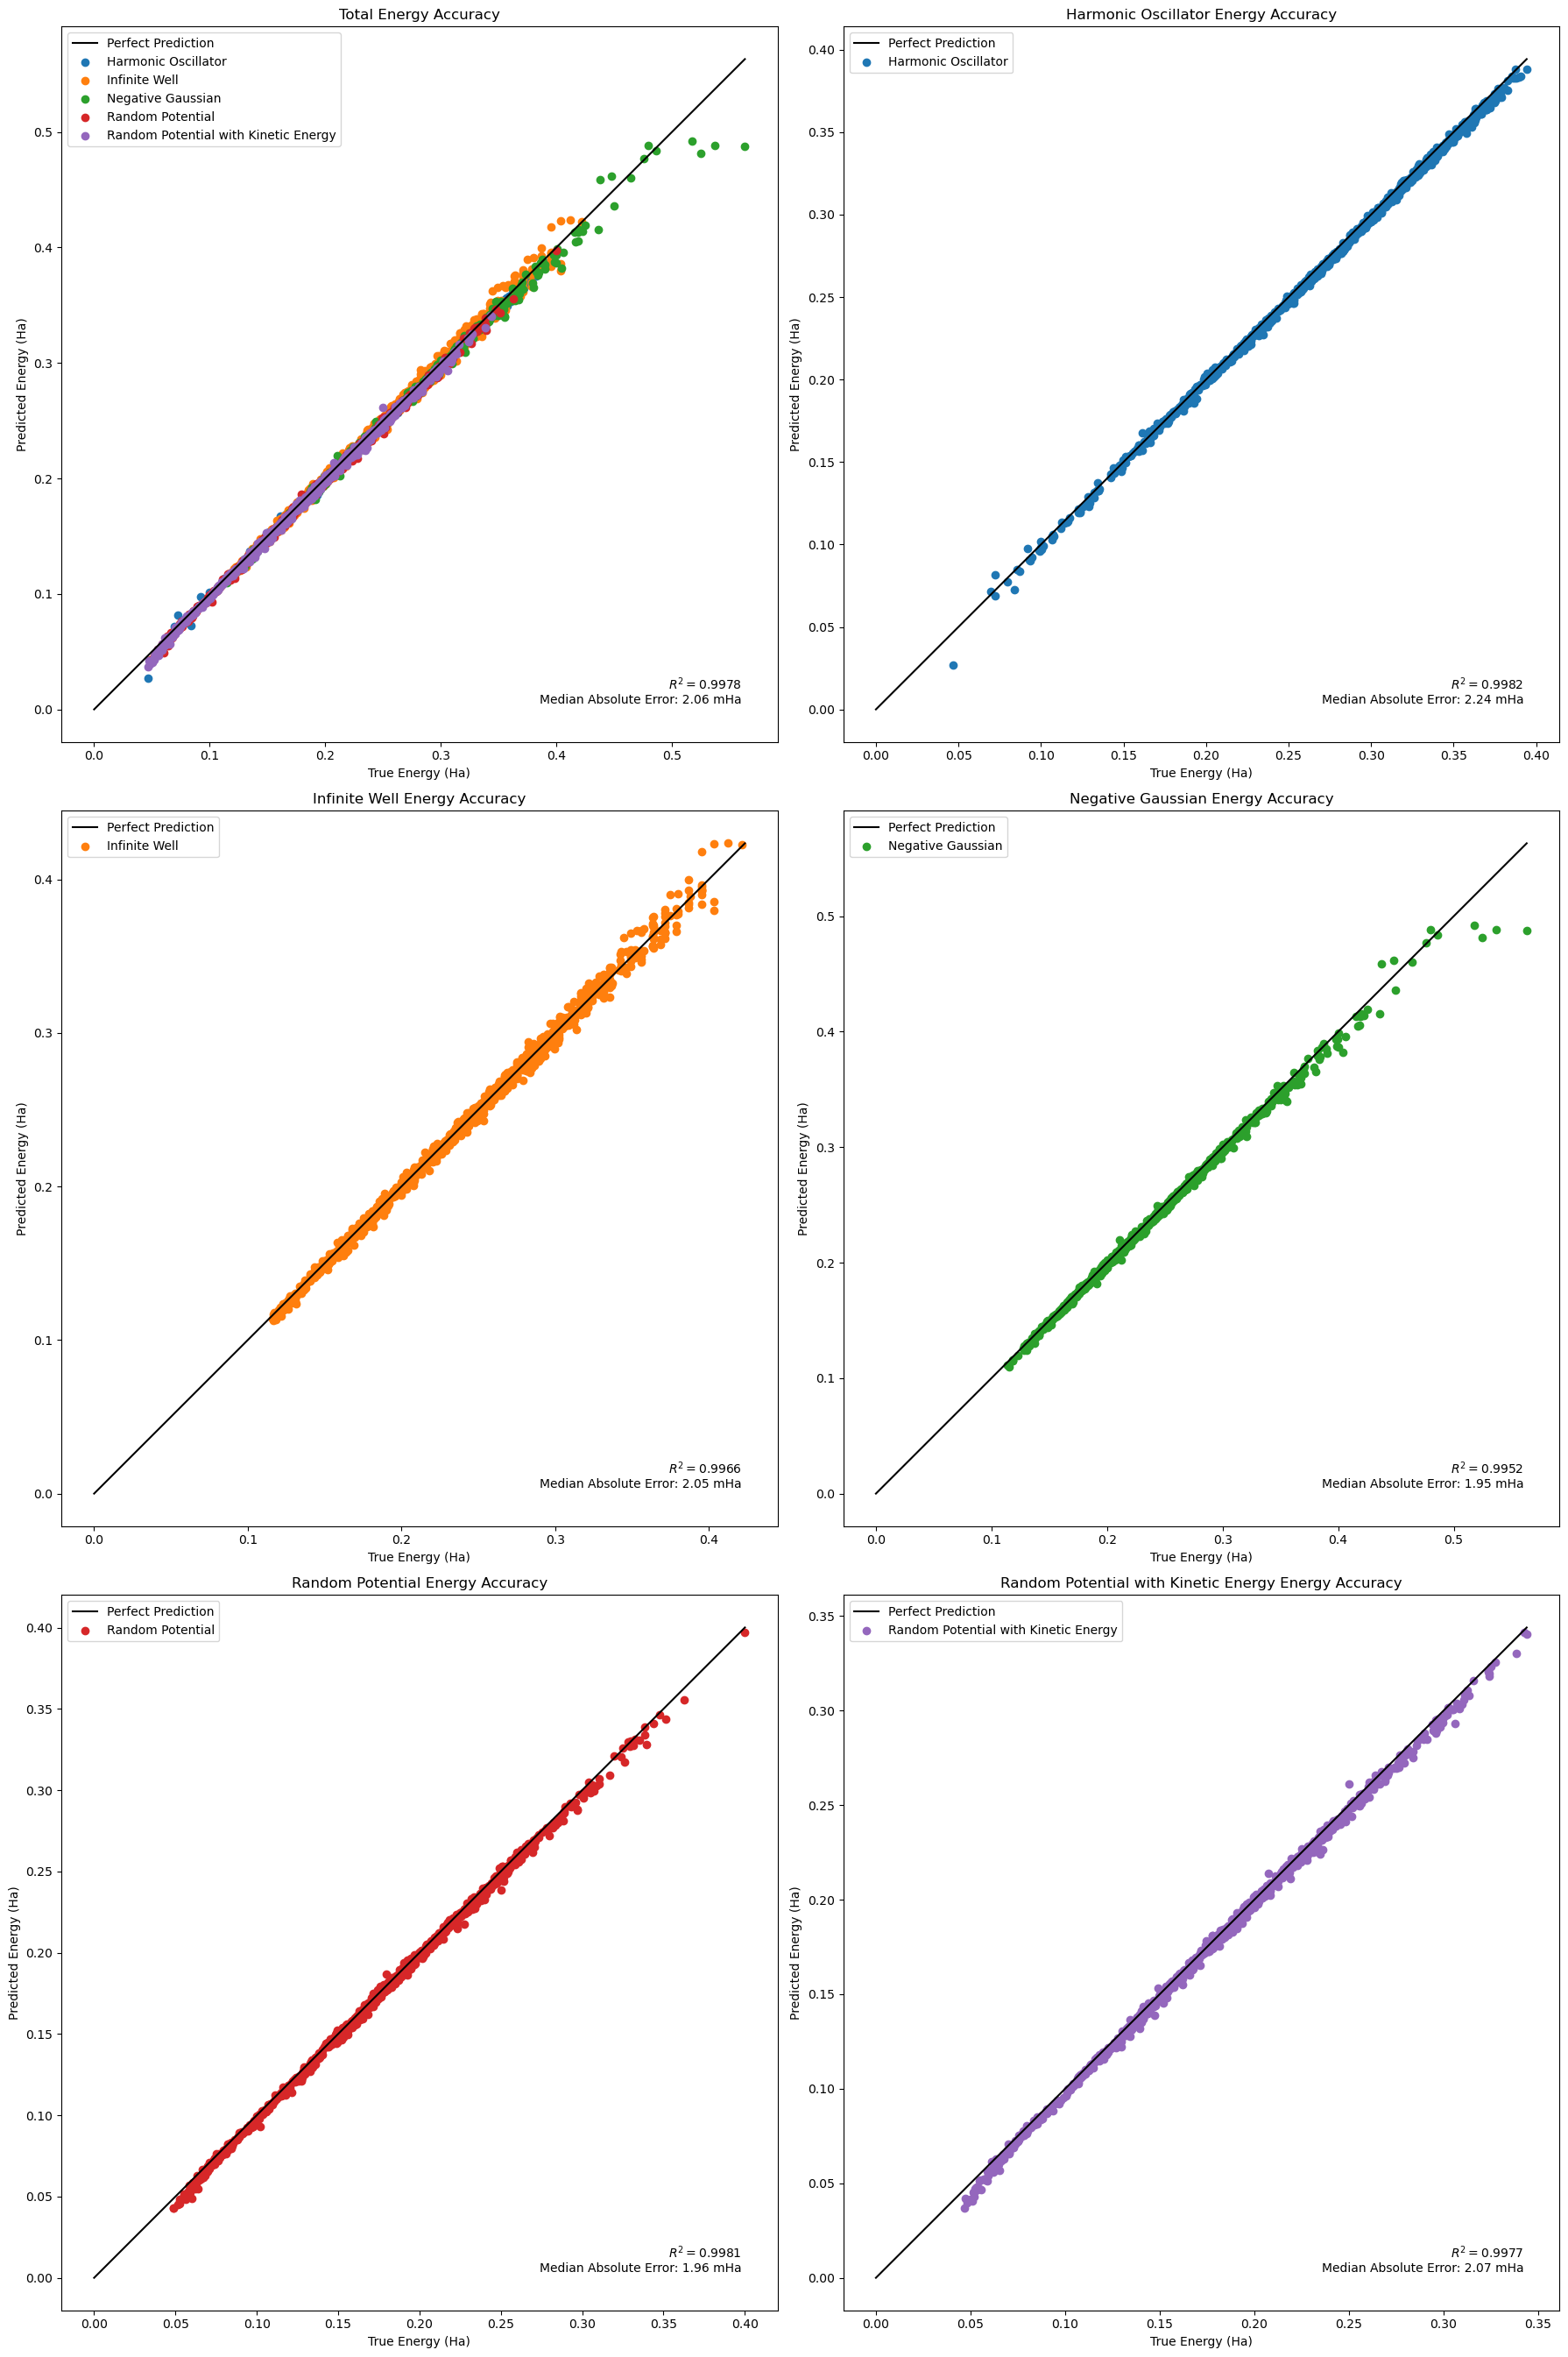

In [7]:
from HelperFunctions.plot_energy import plot_energy

E_pred = []
E_true = []
potential_indices = []

presentation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
for i, data in enumerate(presentation_dataloader):
    potential = data['potential'].to(device)
    energy = data['energy']
    potential_index = data['potential_index']
    E_true.append(energy.item())
    potential_indices.append(potential_index.item())
    with torch.inference_mode():
        E_pred.append(model.forward(potential).item())
plot_energy(E_pred,E_true,file_labels,potential_indices)

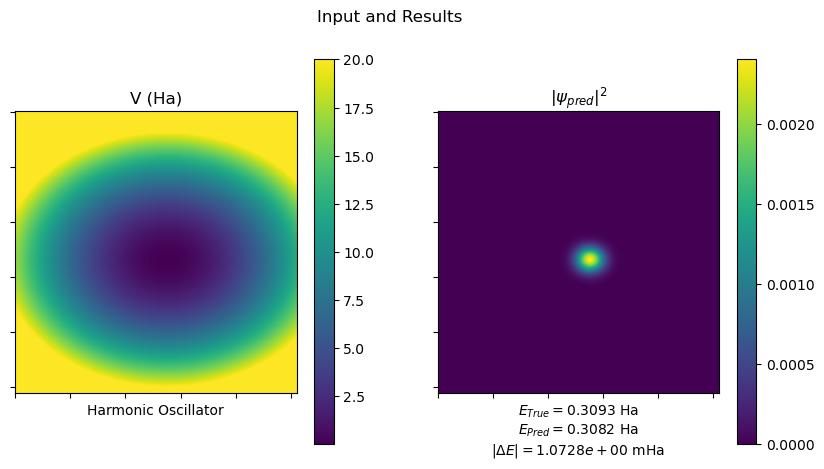

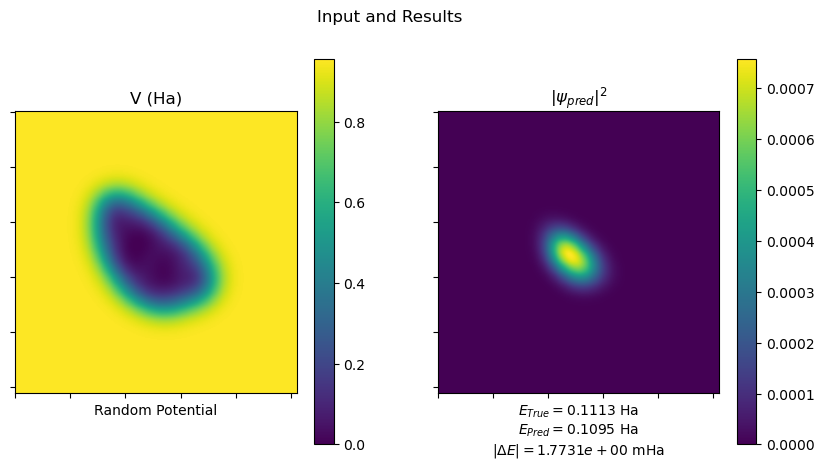

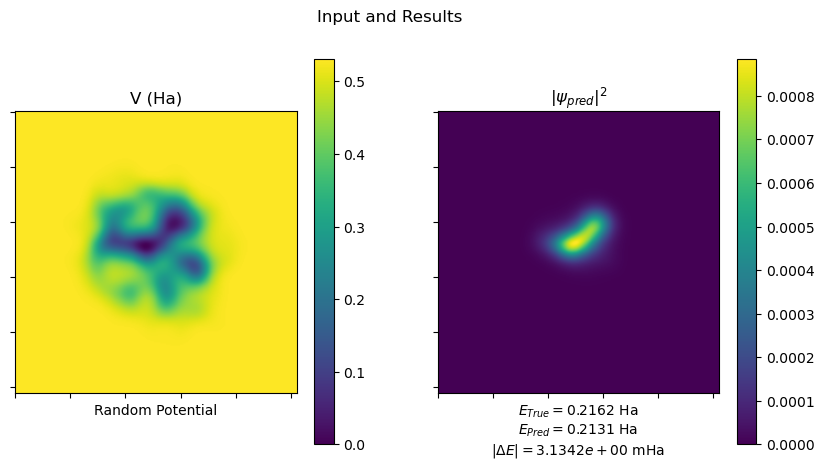

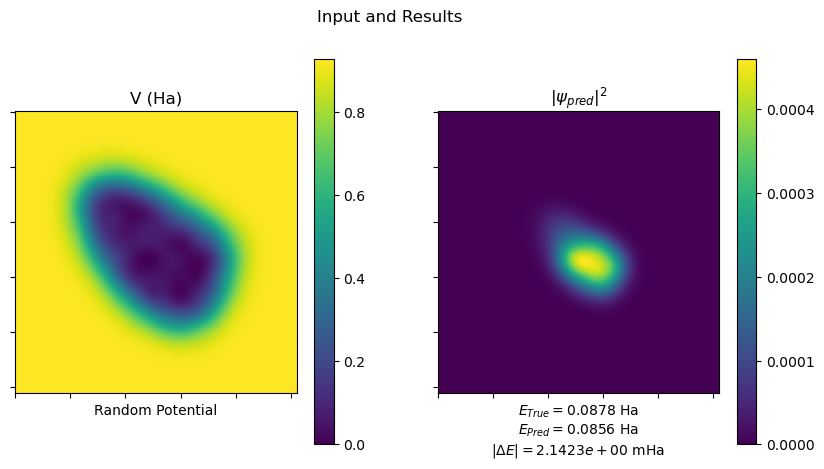

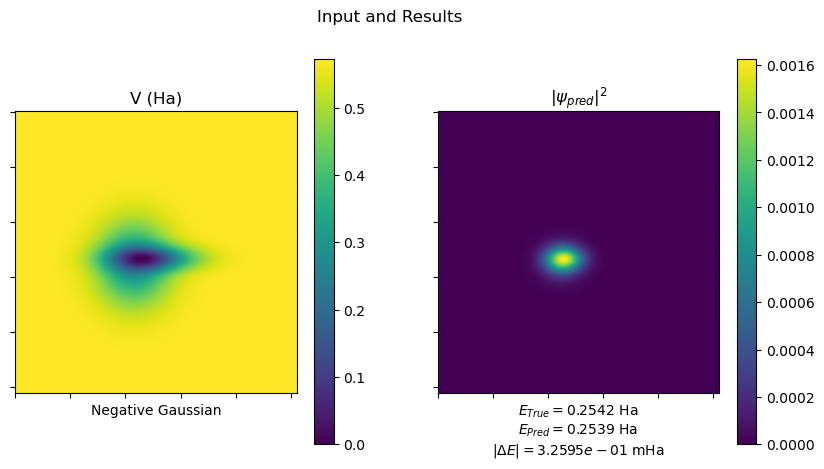

In [8]:

limit = 5
model.eval()
for i, data in enumerate(presentation_dataloader):
    if i >= limit:
        break

    potential = data['potential']
    wavefunction2 = data['wavefunction2']
    energy = data['energy']
    potential_index = data['potential_index']
    with torch.inference_mode():
        energy_pred = model.forward(potential.to(device))
        print_img(potential.squeeze(dim=0),wavefunction2.squeeze(dim=0),'V (Ha)',r'$|\psi_{pred}|^2$','Input and Results',energy,file_labels[potential_index.item()],energy_pred=energy_pred,energy_diff=True)

In [9]:
#torch.save(model.state_dict(), '../Data/backup/e_model_state_dict.pt')